In [1]:
# Relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
# Loading in Data:
data = pd.read_csv("/Users/benfunk/DataspellProjects/MethaneDataScience/Output/LowPPMMatrix.csv")

In [3]:
#calculate absolute humidity in g/m^3
e_sat_standard = 6.112 * np.exp((17.67 * data['Temperature']) / (data['Temperature'] + 243.5))
actual_pressure = data['RelativeHumidity'] * e_sat_standard
xDataAH = (18.02*actual_pressure)/(100*(data['Temperature']+ 273.15)*0.08314)
data['ActualHumidity'] = xDataAH
data['Target PPM'] = data['Target PPM'] #+4.16

In [4]:


p0 = [0.711201, 0.071861, -14.961631, 0.000950, -5.994732, 2.459324, -0.000266, -16.168544, -1.855425]
#p0 = [1] * 9

X = data.drop('Target PPM', axis='columns')
y = data.loc[:, 'Target PPM']

import scipy.optimize as sc
def funkEQ(X, a, b, c, d, e, f, g, h, i):
    R, H, T = X
    with np.errstate(over='ignore'):
        stuff = a**((((-1*R)/(H**b))*c)+(-1*H*d)+(-1*T*e)+(((-1*T*f)/(H**g)))+h) + i
    return stuff

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

popt, pcov = sc.curve_fit(funkEQ, (X_train['Resistance'], X_train['ActualHumidity'], X_train['Temperature']), y_train, p0, maxfev=1000000)

param_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l','m','n','o','p','q','r','s','t','u','v','w']
print(' '.join(f'{name} = {value:.6f}' for name, value in zip(param_names, popt)))

data['Calculated PPM'] = data.apply(lambda row: funkEQ((row['Resistance'], row['ActualHumidity'], row['Temperature']),*popt), axis=1)

# Calculate and print RMSE
y_pred = funkEQ((X_test['Resistance'], X_test['ActualHumidity'], X_test['Temperature']), *popt)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Calculate and print R-Squared
r2 = r2_score(y_test, y_pred) # add this line

print('Root Mean Squared Error:', rmse)
# Calculate and print R-Squared
r2 = r2_score(y_test, y_pred) # add this line
print('R-squared:', r2)


# 0.88

/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_49940/2544101200.py:11: RuntimeWarning: divide by zero encountered in divide
  stuff = a**((((-1*R)/(H**b))*c)+(-1*H*d)+(-1*T*e)+(((-1*T*f)/(H**g)))+h) + i


a = 0.000054 b = -0.433125 c = -0.022453 d = 0.011951 e = 5.509749 f = -5.502321 g = -0.000522 h = -0.504237 i = -3.366137
Root Mean Squared Error: 5.427262602190506
R-squared: 0.8769999053324284


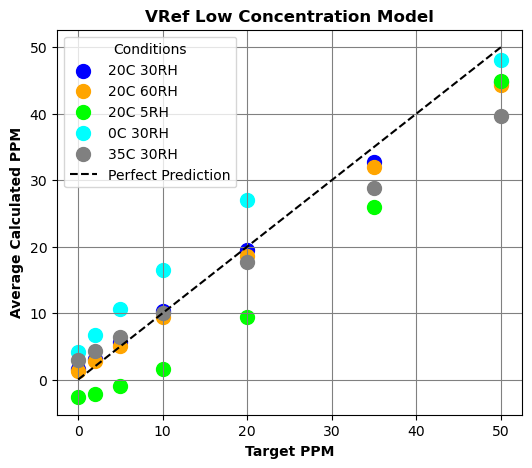

In [5]:
# Adjusting conditions to group them within a range of +-5
'''
Blue 20C 30RH (ambient)
Orange 60C 60RH (hot/humid)
Lime 0C 15RH (cold and dry)
Cyan 0C 60RH
Grey 60C 15RH
'''
conditions = [
    ((data['Temperature'] >= 10) & (data['Temperature'] <= 30) & (data['RelativeHumidity'] >= 20) & (data['RelativeHumidity'] <= 40)),  # Blue
    ((data['Temperature'] >= 10) & (data['Temperature'] <= 30) & (data['RelativeHumidity'] >= 55) & (data['RelativeHumidity'] <= 70)),  # Orange
    ((data['Temperature'] >= 10) & (data['Temperature'] <= 30) & (data['RelativeHumidity'] >= 0) & (data['RelativeHumidity'] <= 10)),   # Lime
    ((data['Temperature'] >= -10) & (data['Temperature'] <= 10) & (data['RelativeHumidity'] >= 20) & (data['RelativeHumidity'] <= 40)),   # Cyan
    ((data['Temperature'] >= 30) & (data['Temperature'] <= 40) & (data['RelativeHumidity'] >= 20) & (data['RelativeHumidity'] <= 40))   # Grey
]

# Assigning labels based on the conditions
labels = ['20C 30RH', '20C 60RH', '20C 5RH', '0C 30RH', '35C 30RH']
data['Label'] = np.select(conditions, labels, default='Other')

# Assigning colors based on the same conditions
colors = ['blue', 'orange', 'lime', 'cyan', 'gray']
data['Color'] = np.select(conditions, colors, default='black')

# Grouping data by Target PPM and Label, then calculating the mean for each group
mean_data = data.groupby(['Target PPM', 'Label', 'Color']).mean().reset_index()

# Setting up the plot
plt.figure(figsize=(6, 5),facecolor='white')
plt.style.use('default')
plt.grid(color='gray')
# Plotting mean points for each Target PPM and condition
for label, color in zip(labels, colors):
    subset = mean_data[mean_data['Label'] == label]
    plt.scatter(subset['Target PPM'], subset['Calculated PPM'], c=color, label=label, s=100, facecolor='white')  # s is the size of the points

# Adding the y=x line to represent perfect prediction
plt.plot([data['Target PPM'].min(), data['Target PPM'].max()], [data['Target PPM'].min(), data['Target PPM'].max()], 'k--', label='Perfect Prediction')

# Adding labels, title, and legend
plt.xlabel('Target PPM', fontweight='bold')
plt.ylabel('Average Calculated PPM', fontweight='bold')
plt.title('VRef Low Concentration Model', fontweight='bold')
plt.tick_params(axis='both', which='major')
plt.legend(title='Conditions')

# Show the plot
plt.show()

In [6]:
# New function to predict resistance
def predict_resistance(ppm, H, T, params):
    def to_solve(R, ppm, H, T, params):
        return funkEQ((R, H, T), *params) - ppm

    R_initial_guess = .05  # Initial guess for R
    R_solution = sc.fsolve(to_solve, R_initial_guess, args=(ppm, H, T, params))
    return R_solution[0]

# Example usage
params = popt  # Assuming popt contains the optimized parameters from curve_fit
H = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
for i in H:
    predicted_R = predict_resistance(ppm=i, H=5, T=20, params=params)
    print(f"Predicted Resistance for PPM={i}, H= 5, T=20: {predicted_R:.2f}")

Predicted Resistance for PPM=0, H= 5, T=20: 11.01
Predicted Resistance for PPM=100, H= 5, T=20: 3.28
Predicted Resistance for PPM=200, H= 5, T=20: 1.75
Predicted Resistance for PPM=300, H= 5, T=20: 0.85
Predicted Resistance for PPM=400, H= 5, T=20: 0.21
Predicted Resistance for PPM=500, H= 5, T=20: -0.29
Predicted Resistance for PPM=600, H= 5, T=20: -0.70
Predicted Resistance for PPM=700, H= 5, T=20: -1.05
Predicted Resistance for PPM=800, H= 5, T=20: -1.35
Predicted Resistance for PPM=900, H= 5, T=20: -1.62
Predicted Resistance for PPM=1000, H= 5, T=20: -1.85
